# Udacity Capstone Project
## Starbucks Promotional Offers
### April 2023

# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

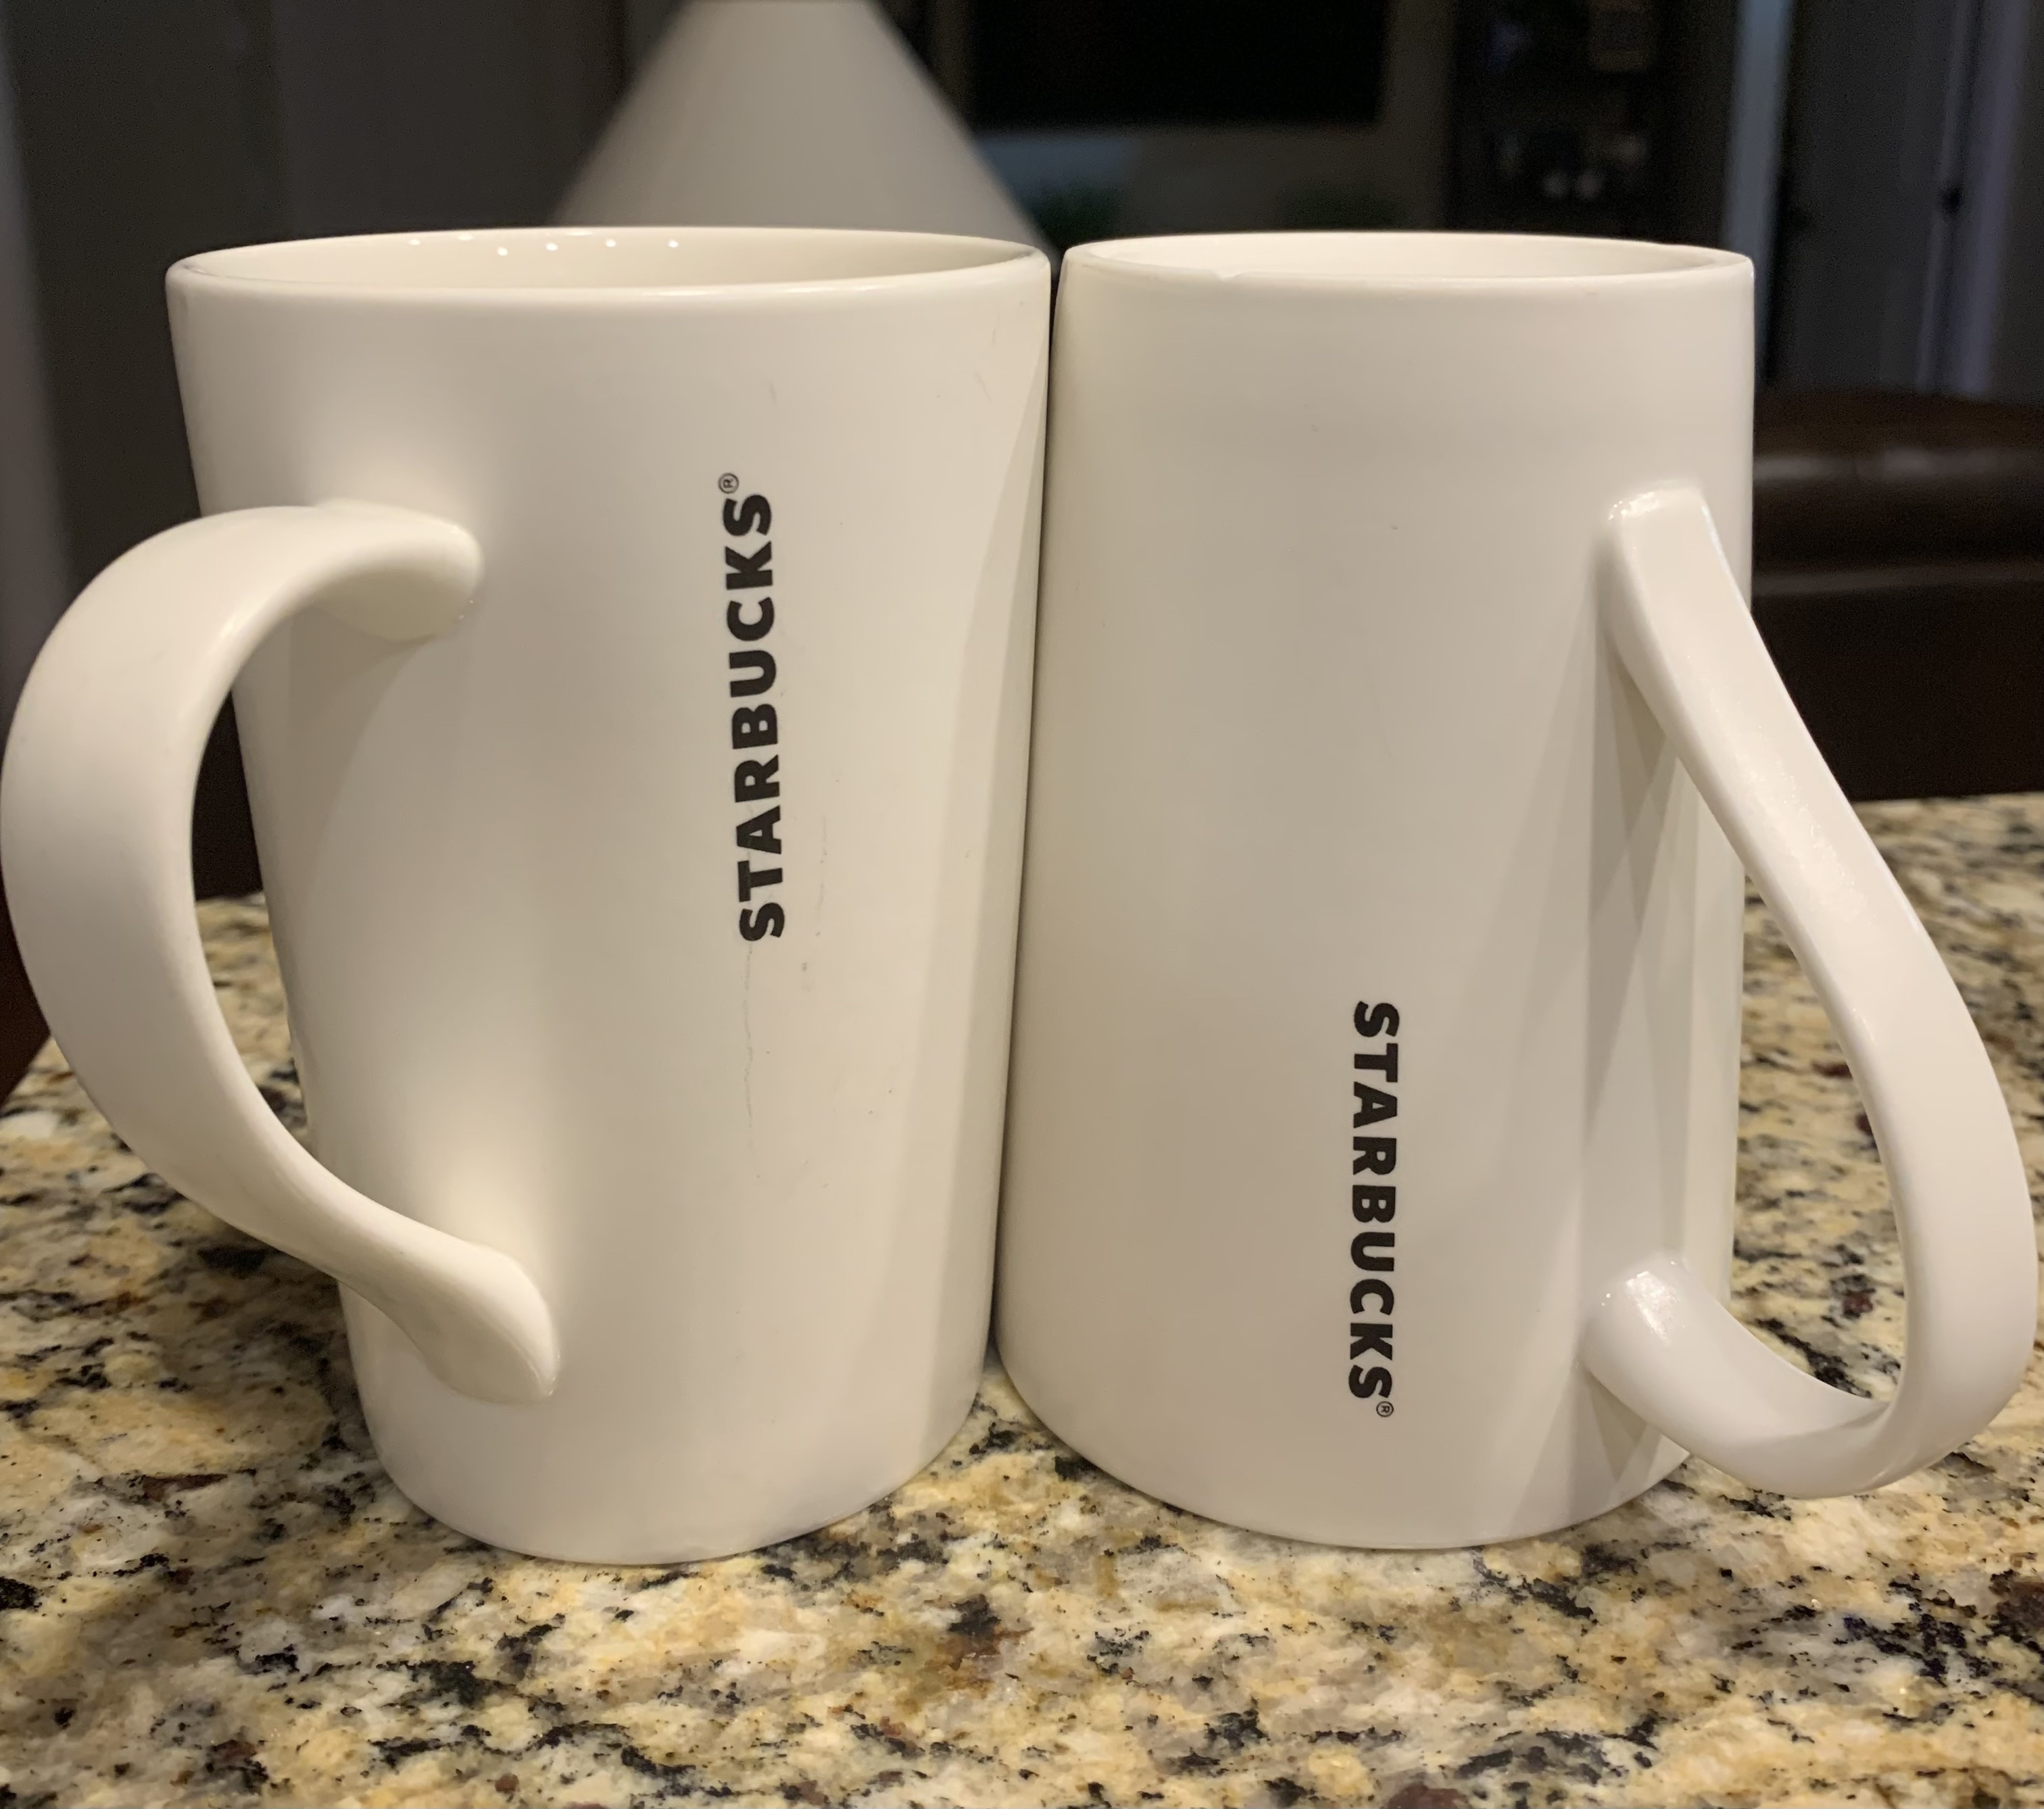

# Data Sets
The data for this project are contained in three files:

- **portfolio.json** - containing offer ids and meta data about each offer (duration, type, etc.)
- **profile.json** - demographic data for each customer
- **transcript.json** - records for transactions, offers received, offers viewed, and offers completed

## Schema details
**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - monetary reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Preliminary Actions
- Display python version
- import necessary libraries
- read in source data

In [1]:
# display python version
from platform import python_version
print(python_version())

3.9.16


In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wrangle_data import clean_portfolio, clean_profile, clean_transcript, merge_data, age_bins, income_bins, extract_offer_id, extract_amount
import recommender as r
from recommender import Recommender
from recommender_functions import create_ranked_offers, popular_recommendations, create_user_item_matrix, find_similar_users, get_offer_ids, get_user_offers, user_user_recs, compute_correlation, compute_euclidean_dist, compute_manhattan_dist
import math
import json
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from math import sqrt
%matplotlib inline

In [3]:
# read in the source json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration
- Explore source data files
    - portfolio.json
    - profile.json
    - transcript.json

### portfolio.json

In [4]:
# look at first few rows
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
# shape of portfolio data
print('Number of portfolio data rows: {}'.format(portfolio.shape[0]))
print('Number of portfolio data columns: {}'.format(portfolio.shape[1]))

Number of portfolio data rows: 10
Number of portfolio data columns: 6


In [6]:
# column information
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [7]:
# any missing values
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [8]:
# summary stats
portfolio.describe().T

,count,mean,std,min,25%,50%,75%,max
reward,10.0,4.2,3.583915,0.0,2.0,4.0,5.0,10.0
difficulty,10.0,7.7,5.831905,0.0,5.0,8.5,10.0,20.0
duration,10.0,6.5,2.321398,3.0,5.0,7.0,7.0,10.0


In [9]:
# how many unique offer ids
print('Unique offer ids: {}'.format(portfolio.id.nunique()))

Unique offer ids: 10


In [10]:
# distribution of offer ids
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [11]:
# distribution of offer durations
portfolio.duration.value_counts()

7     4
5     2
10    2
4     1
3     1
Name: duration, dtype: int64

In [12]:
portfolio.channels.value_counts()

[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64

### profile.json

In [13]:
# look at first few rows
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
# shape of profile data
print('Number of profile data rows: {}'.format(profile.shape[0]))
print('Number of profile data columns: {}'.format(profile.shape[1]))

Number of profile data rows: 17000
Number of profile data columns: 5


In [15]:
# column information
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [16]:
# any missing values
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [17]:
# summary stats
profile.describe().T

,count,mean,std,min,25%,50%,75%,max
age,17000.0,6.253141e+01,26.738580,18.0,45.0,58.0,73.0,118.0
became_member_on,17000.0,2.016703e+07,11677.499961,20130729.0,20160526.0,20170802.0,20171230.0,20180726.0
income,14825.0,6.540499e+04,21598.299410,30000.0,49000.0,64000.0,80000.0,120000.0


In [18]:
# 118 seems a bit high for max age
profile.loc[profile['age'] == 118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [19]:
# gender distribution
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [20]:
profile.gender.value_counts() / profile.shape[0]

M    0.499059
F    0.360529
O    0.012471
Name: gender, dtype: float64

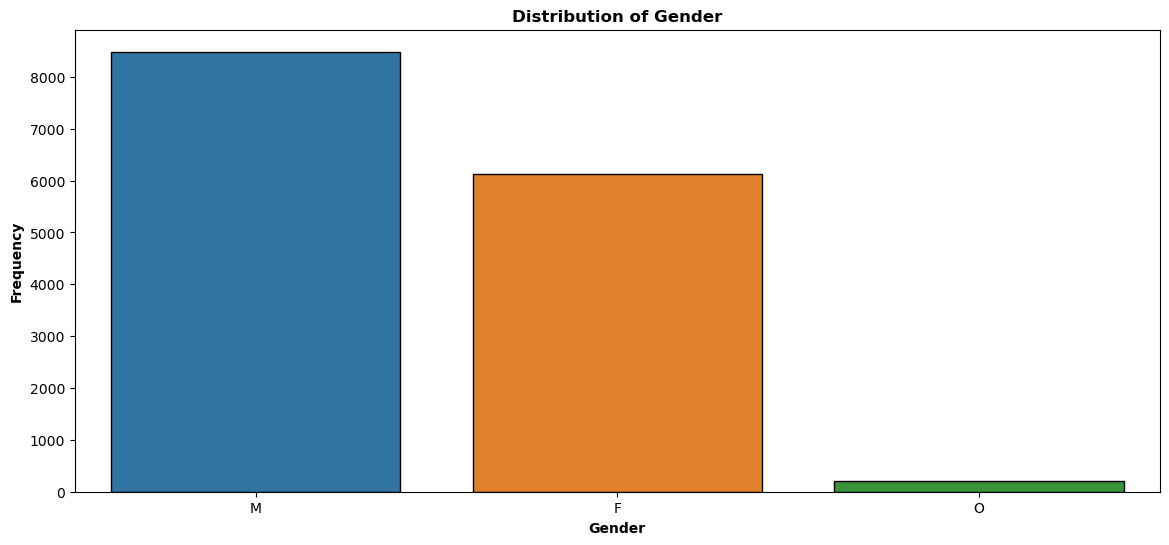

In [21]:
# distribution of gender
plt.figure(figsize = (14, 6))
sns.barplot(data = profile,  x = profile.gender.value_counts().index, y = profile.gender.value_counts(),
           edgecolor = 'black')
plt.xlabel('Gender', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Distribution of Gender', weight = 'bold');

### transcript.json

In [22]:
# look at first few rows
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [23]:
# shape of transcript data
print('Number of transcript data rows: {}'.format(transcript.shape[0]))
print('Number of transcript data columns: {}'.format(transcript.shape[1]))

Number of transcript data rows: 306534
Number of transcript data columns: 4


In [24]:
# column information
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [25]:
# any missing values
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [26]:
# what are the unique events
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [27]:
# what are the event counts
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

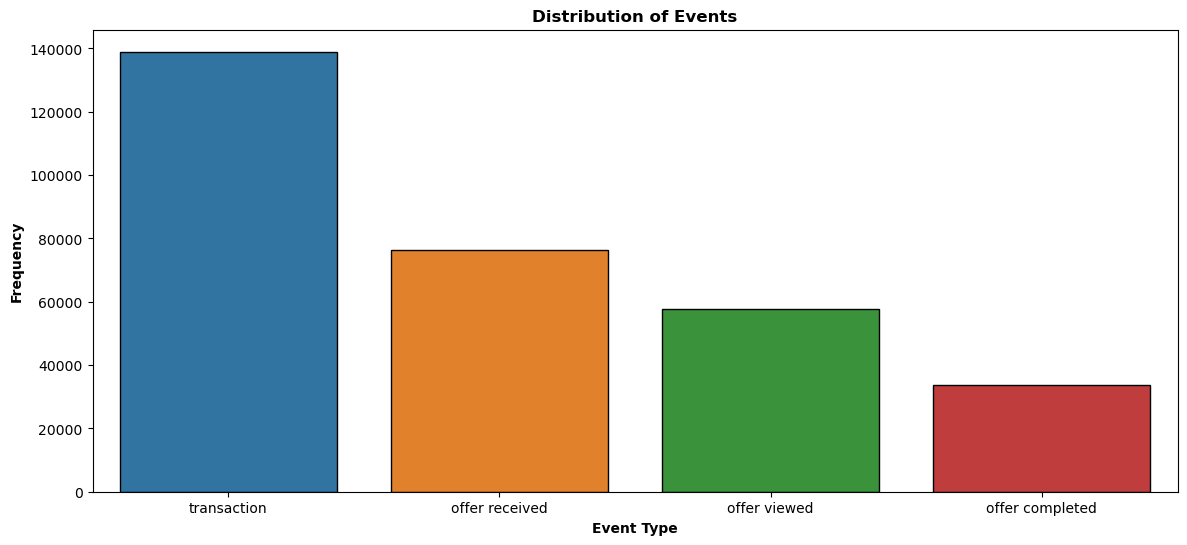

In [28]:
# distribution of events
plt.figure(figsize = (14, 6))
sns.barplot(data = transcript,  x = transcript.event.value_counts().index, y = transcript.event.value_counts(),
           edgecolor = 'black')
plt.xlabel('Event Type', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Distribution of Events', weight = 'bold');

In [29]:
# what do the various events look like
print('Transaction: ', transcript.query('event == "transaction"')['value'].iloc[0])
print('Offer received: ', transcript.query('event == "offer received"')['value'].iloc[0])
print('Offer viewed: ', transcript.query('event == "offer viewed"')['value'].iloc[0])
print('Offer completed: ', transcript.query('event == "offer completed"')['value'].iloc[0])

Transaction:  {'amount': 0.8300000000000001}
Offer received:  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
Offer viewed:  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
Offer completed:  {'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}


### Data Observations
#### portfolio.json
- channels can be one-hot encoded
- offer_type can be one-hot encoded
- id column is offer_id
- there are no missing values

#### profile.json 
- id in this data set is a customer id
- gender and income each have 2175 missing values. 
- maximum age is 118, which appears out of line. 
- age = 118 is in the same 2175 records with missing gender and income.
- became_member_on is a data field, but represented as integer

#### transcript.json 
- time column represents hours since start of test, but is integer format
- people column is equivalent to customer id in profile dataset

## Data Cleaning

#### portfolio dataframe
- rename "id" column to "offer_id"
- rename "duration" column to "days_open"
- rename "difficulty" column to "min_spend"
- one-hot encode "channels" column
- one-hot encode "offer_type" column
- drop "channels" and "offer_type" columns after one-hot encoding

In [30]:
# call clean_portfolio function to clean the portfolio dataset
portfolio_clean = clean_portfolio()
portfolio_clean

,offer_id,reward,min_spend,days_open,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,0,1,0,1,0


#### profile dataframe
- rename "id" column to "customer_id"
- remove the 2175 rows where "gender" and "income" have missing values and "age" equals 118
- one-hot encode 'gender' column
- convert "became_member_on" to datetime and label "membership_start"
- create "membership_year" from "membership_start"
- reorder columns

In [31]:
# call clean_profile to clean profile data
profile_clean = clean_profile()
profile_clean.head()

,customer_id,age,income,female,male,membership_start,membership_year
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,1,0,2017-07-15,2017
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1,0,2017-05-09,2017
5,e2127556f4f64592b11af22de27a7932,68,70000.0,0,1,2018-04-26,2018
8,389bc3fa690240e798340f5a15918d5c,65,53000.0,0,1,2018-02-09,2018
12,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,0,1,2017-11-11,2017


#### transcript dataframe
- rename 'person' column to 'customer_id'
- one-hot encode 'event' column
- split transcript dataframe into transaction and offers dataframes
- extract 'offer_id' from 'value' column
- extract 'transaction' from 'value' column
- drop unneeded columns

In [32]:
# call clean_transcript to clean transcript data
transcript_clean = clean_transcript()

In [33]:
transcript_clean.head()

,offer_id,customer_id,offer_completed,offer_received,offer_viewed,amount,time
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,NaN,0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0,1,0,NaN,0
2,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,1,0,NaN,0
3,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,NaN,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,0,1,0,NaN,0


### Merge dataframes and write out resultant dataframe to csv

In [34]:
# call merge_data to merge cleaned data sets and write out to csv
merge_data(portfolio_clean, profile_clean, transcript_clean)

In [35]:
# read in cleaned data and display first couple of rows
combined_df = pd.read_csv('data/starbucks_combined_data.csv')
combined_df.head()

,offer_id,customer_id,offer_completed,offer_received,offer_viewed,amount,time,reward,min_spend,days_open,...,web,bogo,discount,informational,age,income,female,male,membership_start,membership_year
0,6,7996,0,1,0,NaN,0,5.0,5.0,7.0,...,1.0,1.0,0.0,0.0,75.0,100000.0,1.0,0.0,2017-05-09,2017.0
1,0,10735,0,1,0,NaN,0,5.0,20.0,10.0,...,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,15043,0,1,0,NaN,0,2.0,10.0,7.0,...,1.0,0.0,1.0,0.0,68.0,70000.0,0.0,1.0,2018-04-26,2018.0
3,9,9524,0,1,0,NaN,0,2.0,10.0,10.0,...,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,6939,0,1,0,NaN,0,10.0,10.0,5.0,...,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## Data Exploration and Analysis

In [36]:
# shape of combined_df
print('Number of combined_df data rows: {}'.format(combined_df.shape[0]))
print('Number of combined_df data columns: {}'.format(combined_df.shape[1]))

Number of combined_df data rows: 306534
Number of combined_df data columns: 23


#### For comparison, it may be useful to bucket 'age' and 'income' into ranges.

In [37]:
# 'age' summary stats - offers dataset
combined_df['age'].describe().T

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

> Average age is approximately 54 years old.

In [38]:
# 'income' summary stats - offers dataset
combined_df['income'].describe().T

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

> Average income is approximately 64,000

In [39]:
# create age bins in offers dataset
combined_df = age_bins(combined_df)
combined_df.head()

,offer_id,customer_id,offer_completed,offer_received,offer_viewed,amount,time,reward,min_spend,days_open,...,female,male,membership_start,membership_year,18-29,30-44,45-59,60-74,75-89,90-101
0,6,7996,0,1,0,NaN,0,5.0,5.0,7.0,...,1.0,0.0,2017-05-09,2017.0,0,0,0,0,1,0
1,0,10735,0,1,0,NaN,0,5.0,20.0,10.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,2,15043,0,1,0,NaN,0,2.0,10.0,7.0,...,0.0,1.0,2018-04-26,2018.0,0,0,0,1,0,0
3,9,9524,0,1,0,NaN,0,2.0,10.0,10.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
4,4,6939,0,1,0,NaN,0,10.0,10.0,5.0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [40]:
# create income bins in offers dataset
combined_df = income_bins(combined_df)
combined_df.head()

,offer_id,customer_id,offer_completed,offer_received,offer_viewed,amount,time,reward,min_spend,days_open,...,30-44,45-59,60-74,75-89,90-101,30k-49k,50k-69k,70k-89k,90k-109k,110k-120k
0,6,7996,0,1,0,NaN,0,5.0,5.0,7.0,...,0,0,0,1,0,0,0,0,1,0
1,0,10735,0,1,0,NaN,0,5.0,20.0,10.0,...,0,0,0,0,0,0,0,0,0,0
2,2,15043,0,1,0,NaN,0,2.0,10.0,7.0,...,0,0,1,0,0,0,0,1,0,0
3,9,9524,0,1,0,NaN,0,2.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,0
4,4,6939,0,1,0,NaN,0,10.0,10.0,5.0,...,0,0,0,0,0,0,0,0,0,0


### Look at some simple frequency distributions

In [41]:
# create age and income dictionaries
age_cols = ['18-29', '30-44', '45-59', '60-74', '75-89', '90-101']
income_cols = ['30k-49k', '50k-69k', '70k-89k', '90k-109k', '110k-120k']

In [42]:
# age distribution in offers
age_dist = combined_df[combined_df['offer_completed'] == 1][age_cols].sum().reset_index()
age_dist

,index,0
0,18-29,2577
1,30-44,5126
2,45-59,11014
3,60-74,9351
4,75-89,3618
5,90-101,629


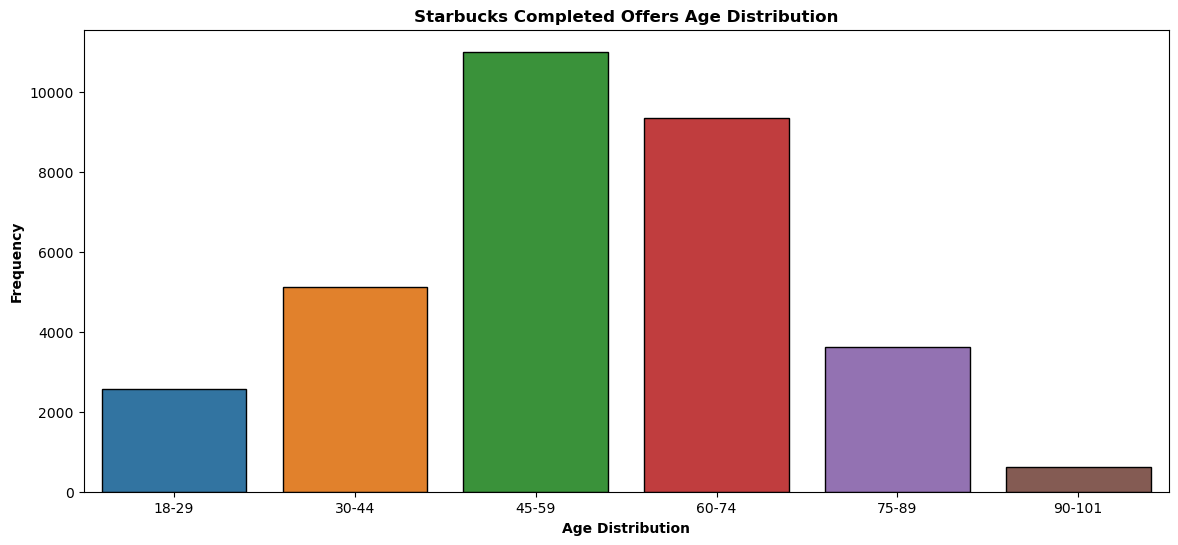

In [43]:
# age distribution for completed offers
plt.figure(figsize = (14, 6))
sns.barplot(data = age_dist, x = 'index', y = age_dist[0], edgecolor = 'black')
plt.xlabel('Age Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers Age Distribution', weight = 'bold');

> The bulk of Starbucks customers with completed offers fall in the 45 to 59-years and 60 to 74-years age groups.

In [44]:
# income distribution in offers
income_dist = combined_df[combined_df['offer_completed'] == 1][income_cols].sum().reset_index()
income_dist

,index,0
0,30k-49k,5943
1,50k-69k,10521
2,70k-89k,9535
3,90k-109k,4865
4,110k-120k,1460


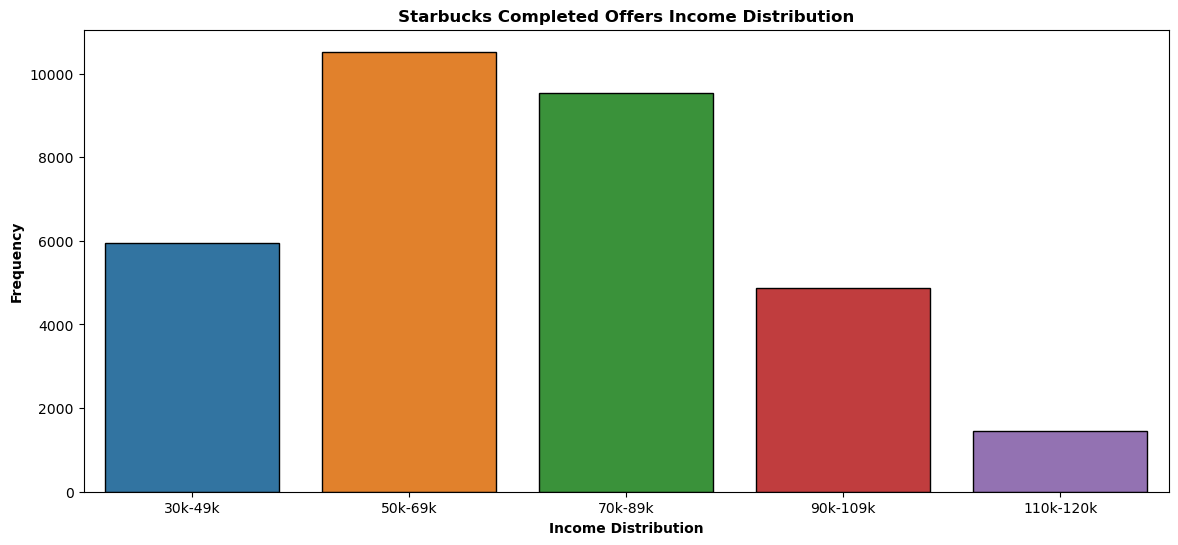

In [45]:
# income distribution for completed offers
plt.figure(figsize = (14, 6))
sns.barplot(data = income_dist, x = 'index', y = income_dist[0], edgecolor = 'black')
plt.xlabel('Income Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers Income Distribution', weight = 'bold');

> The bulk of Starbucks customers with completed offers fall in the 50K-69K and 70K-89K income ranges.

In [46]:
# offer type distribution in offers
offer_type_cols = ['bogo', 'discount']
offer_type_dist = combined_df[combined_df['offer_completed'] == 1][offer_type_cols].sum().reset_index()
offer_type_dist

,index,0
0,bogo,15669.0
1,discount,17910.0


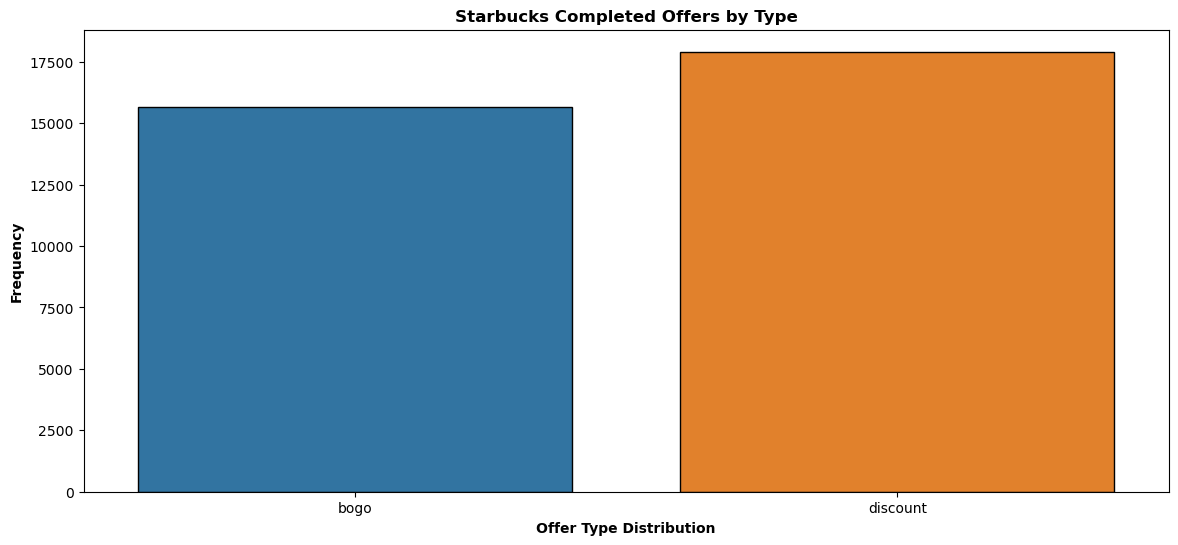

In [47]:
# distribution of offer type for completed offers
plt.figure(figsize = (14, 6))
sns.barplot(data = offer_type_dist, x = 'index', y = offer_type_dist[0], edgecolor = 'black')
plt.xlabel('Offer Type Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers by Type', weight = 'bold');

> Discount offers are slightly more prevelant than bogo.

In [48]:
channels_cols = ['email', 'mobile', 'social', 'web']
offer_channels_dist = combined_df[combined_df['offer_completed'] == 1][channels_cols].sum().reset_index()
offer_channels_dist

,index,0
0,email,33579.0
1,mobile,30159.0
2,social,21788.0
3,web,29891.0


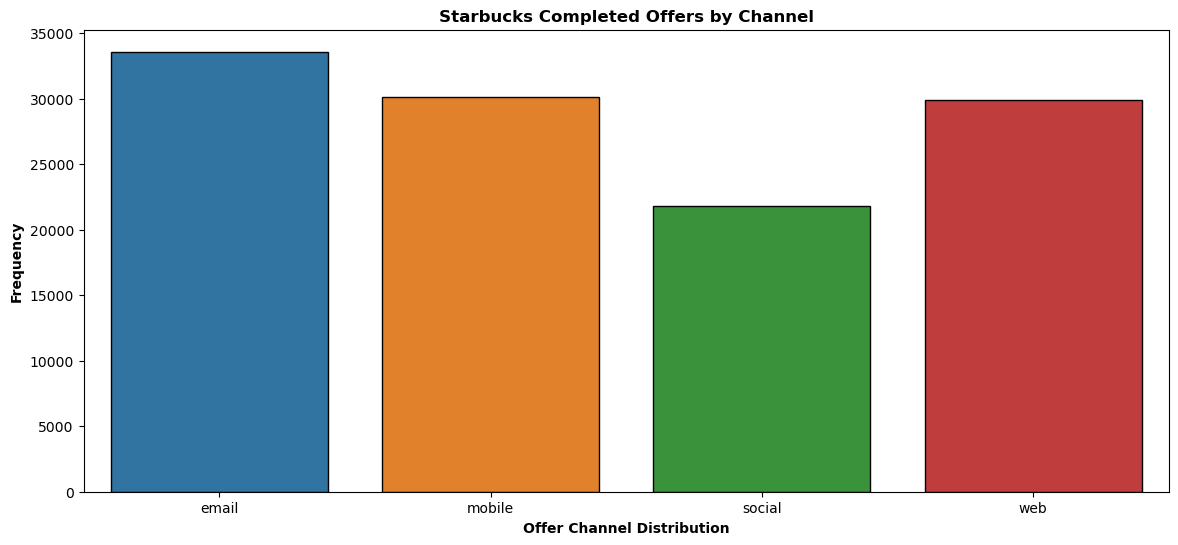

In [49]:
# distribution of offer channel for completed offers
plt.figure(figsize = (14, 6))
sns.barplot(data = offer_channels_dist, x = 'index', y = offer_channels_dist[0], edgecolor = 'black')
plt.xlabel('Offer Channel Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers by Channel', weight = 'bold');

> Email channel frequency is slightly higher than mobile and web.

In [50]:
# offer type distribution in offers
gender_cols = ['male', 'female']
gender_dist = combined_df[combined_df['offer_completed'] == 1][gender_cols].sum().reset_index()
gender_dist

,index,0
0,male,16466.0
1,female,15477.0


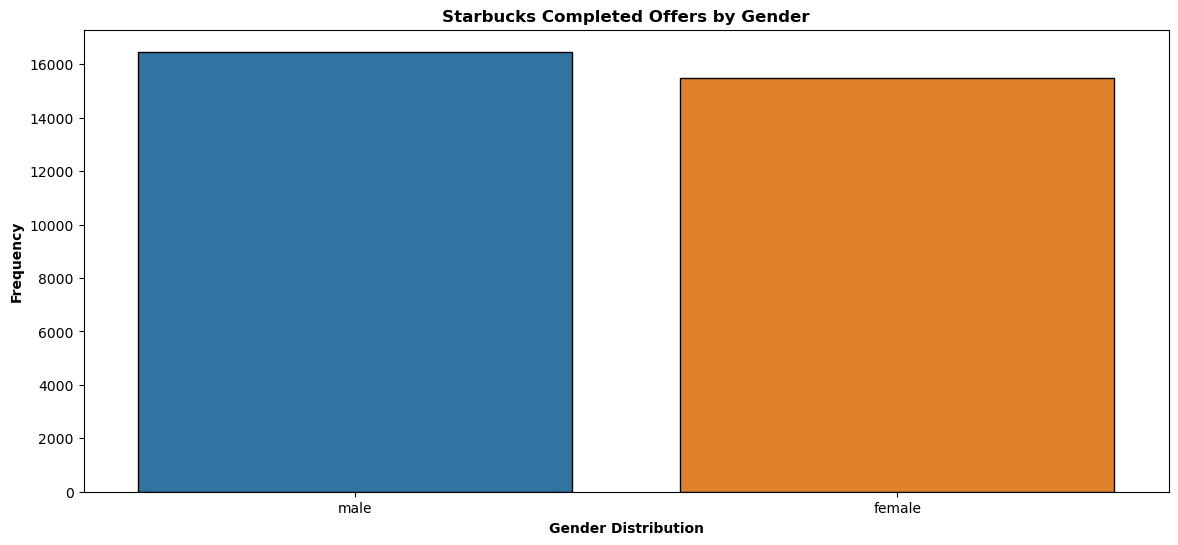

In [51]:
# gender distribution for completed offers
plt.figure(figsize = (14, 6))
sns.barplot(data = gender_dist, x = 'index', y = gender_dist[0], edgecolor = 'black')
plt.xlabel('Gender Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Completed Offers by Gender', weight = 'bold');

> Slightly higher number of completed offers for male customers.

In [52]:
# age distribution of transaction data
t_age_dist = combined_df[combined_df['amount'] > 0][age_cols].sum().reset_index()
t_age_dist

,index,0
0,18-29,15528
1,30-44,24294
2,45-59,37873
3,60-74,31511
4,75-89,12022
5,90-101,2030


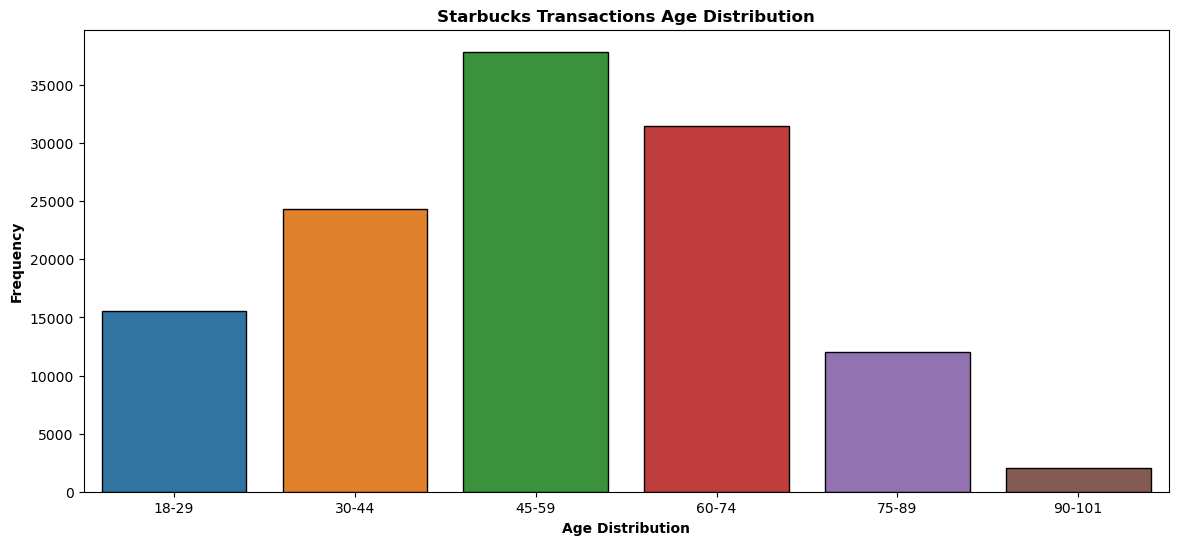

In [53]:
# distribution of age for Starbucks transactions
plt.figure(figsize = (14, 6))
sns.barplot(data = t_age_dist, x = 'index', y = t_age_dist[0], edgecolor = 'black')
plt.xlabel('Age Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Transactions Age Distribution', weight = 'bold');

> Similar to the completed offers data, the bulk of transaction data is in the 45-years to 74-years age groups.

In [54]:
# income distribution of transaction data
t_income_dist = combined_df[combined_df['amount'] > 0][income_cols].sum().reset_index()
t_income_dist

,index,0
0,30k-49k,37075
1,50k-69k,45035
2,70k-89k,26610
3,90k-109k,11178
4,110k-120k,3185


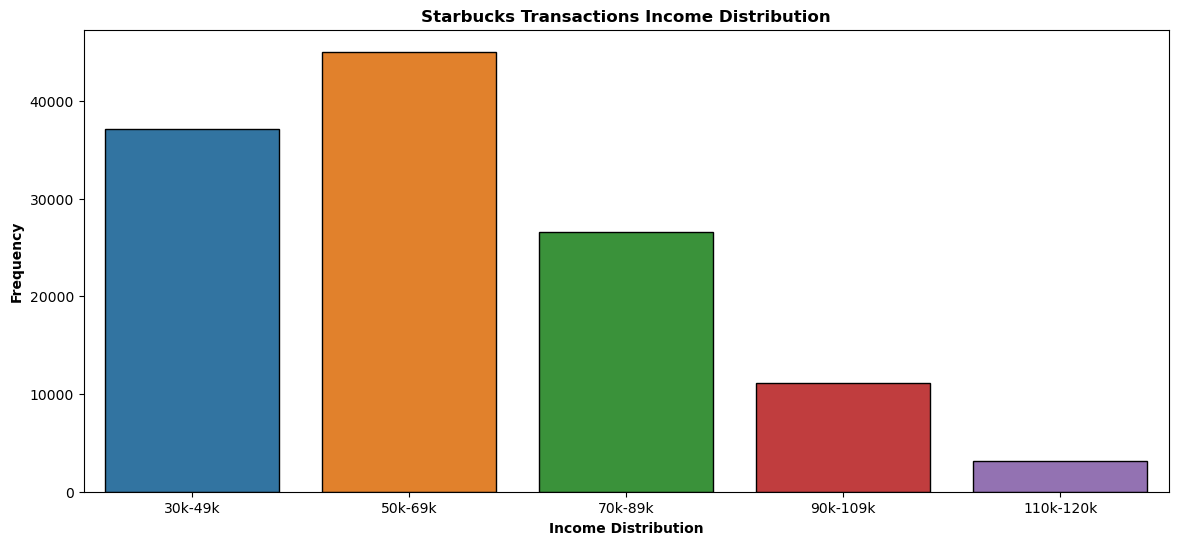

In [55]:
# distribution of income for Starbucks transactions
plt.figure(figsize = (14, 6))
sns.barplot(data = t_income_dist, x = 'index', y = t_income_dist[0], edgecolor = 'black')
plt.xlabel('Income Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Transactions Income Distribution', weight = 'bold');

> Income distribution is shifted lower with the transaction data, with the bulk in the 30,000 to 69,000 range.

In [56]:
# gender distribution of transaction data
t_gender_dist = combined_df[combined_df['amount'] > 0][gender_cols].sum().reset_index()
t_gender_dist

,index,0
0,male,72794.0
1,female,49382.0


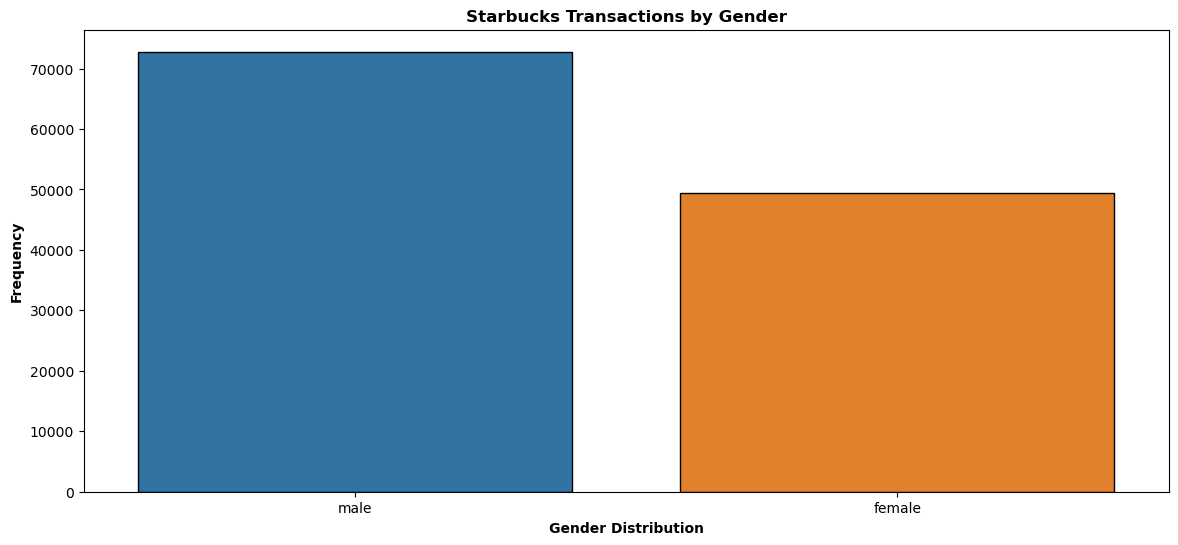

In [57]:
# distribution of gender for Starbucks transactions
plt.figure(figsize = (14, 6))
sns.barplot(data = t_gender_dist, x = 'index', y = t_gender_dist[0], edgecolor = 'black')
plt.xlabel('Gender Distribution', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Starbucks Transactions by Gender', weight = 'bold');

> Transactions for males are significantly higher.

In [58]:
# which customers are the big spenders
top_amounts = combined_df.groupby('customer_id')['amount'].sum().nlargest(10).reset_index()
top_amounts

,customer_id,amount
0,4029,1608.69
1,16081,1365.66
2,11703,1327.74
3,6519,1321.42
4,7673,1319.97
5,5494,1292.86
6,11615,1258.19
7,14016,1251.99
8,9913,1232.40
9,6640,1211.76


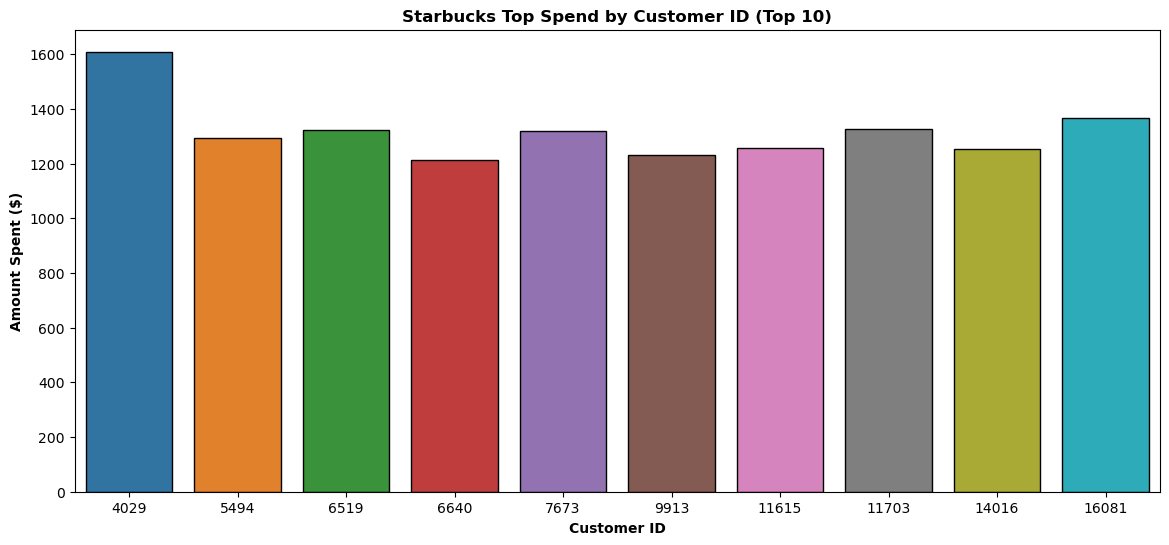

In [59]:
# amopunt spent by customer id - top 10
plt.figure(figsize = (14, 6))
sns.barplot(data = top_amounts, x = 'customer_id', y = 'amount', edgecolor = 'black')
plt.xlabel('Customer ID', weight = 'bold')
plt.ylabel('Amount Spent ($)', weight = 'bold')
plt.title('Starbucks Top Spend by Customer ID (Top 10)', weight = 'bold');

> Customer ID 4029 has spent more than 200 dollars above the nearest customer ID.

### Most Popular Recommendation
1. Rank offers based on ratio of offers_viewed to offers_received
2. Determine the most popular offers_ids based on rank

In [60]:
# offers ranked by viewed_ratio (offers_viewed / offers_received)
ranked_viewed = create_ranked_offers(combined_df)
ranked_viewed

,offer_id,offer_received,offer_viewed,viewed_ratio
9,9,7597,7327,0.964460
4,4,7593,7298,0.961148
1,1,7646,7337,0.959587
8,8,7571,7264,0.959451
5,5,7618,6687,0.877789
7,7,7658,6716,0.876991
3,3,7617,4144,0.544046
6,6,7677,4171,0.543311
2,2,7632,4118,0.539570
0,0,7668,2663,0.347287


In [61]:
# get most popular offer recommendations for a customer
customer_id = 13234
num_offers = 5
recs = popular_recommendations(customer_id, num_offers, ranked_viewed)
recs

The top 5 offer recommendations for customer 13234:


[9, 4, 1, 8, 5]

In [62]:
# test function handles invalid input
customer_id = 13234
num_offers = 25
recs_err = popular_recommendations(customer_id, num_offers, ranked_viewed)
recs_err

Please enter an offer_id value less than or equal to 10.


### User-user collaborative filtering
1. Create user item matrix
    - Each **customer** should only appear in each row once.
    - Each **offer** should only show up in one column.
    - If a customer has viewed an offer, then place a 1 where the customer-row meets for that offer-column. It does not matter how many times a customer has interacted with the offer, all entries where a customer has interacted with an offer should be a 1.
    - If a customer has not interacted with an offer, then place a zero where the customer-row meets for that offer-column.
2. Call *find_similar_users* to find customers similar to the input customer_id
    - take a customer_id and provide an ordered list of the most similar customers to that customer (from most similar to least similar). The returned result should not contain the provided customer_id, as we know that each customer is similar to him/herself.

In [63]:
# create the user item matrix
user_item_matrix = create_user_item_matrix(combined_df)
user_item_matrix.head()

offer_id,0,1,2,3,4,5,6,7,8,9,10
customer_id,,,,,,,,,,,
0,0,0,1,1,0,1,0,0,1,1,1
1,0,0,0,0,0,0,0,0,1,0,1
2,1,1,0,1,0,1,1,0,0,0,1
3,0,0,0,0,1,1,0,1,0,1,1
4,0,1,0,0,0,1,1,0,1,0,1


In [64]:
# shape of the user item matrix
print('User item matrix rows: ', user_item_matrix.shape[0])
print('User item matrix columns: ', user_item_matrix.shape[1])

User item matrix rows:  17000
User item matrix columns:  11


#### Find simlar users

In [65]:
# Call find_similar_users, passing in customer_id and user item matrix
print("The 10 most similar users to user 13234 are: {}".format(find_similar_users(13234, user_item_matrix)[:10]))
print("The 5 most similar users to user 1759 are: {}".format(find_similar_users(1759, user_item_matrix)[:5]))
print("The 3 most similar users to user 203 are: {}".format(find_similar_users(203, user_item_matrix)[:3]))

The 10 most similar users to user 13234 are: [5439, 13757, 3133, 10578, 3156, 15533, 15511, 8177, 1055, 11821]
The 5 most similar users to user 1759 are: [10807, 5323, 647, 6571, 4228]
The 3 most similar users to user 203 are: [5132, 11254, 487]


### Collaborative Filtering
1. Create user item matrix
    - same as above. Not really necessary, but creating fresh version for this section
2. Get a list of offer_ids
    - call *get_offer_ids* function
3. Get a list of offer_ids for a given customer
    - call *get_user_offers* function
4. Make recommendations based on closeness to a customer
    - call *user_user_recs* function
5. Compute correlation between two customers
6. Compute Euclidean distance between two customers
7. Compute Manhattan distance between two customers

In [66]:
# create the user item matrix for user-user collaborative filtering
customer_by_offerid = create_user_item_matrix(combined_df)
customer_by_offerid.head()

offer_id,0,1,2,3,4,5,6,7,8,9,10
customer_id,,,,,,,,,,,
0,0,0,1,1,0,1,0,0,1,1,1
1,0,0,0,0,0,0,0,0,1,0,1
2,1,1,0,1,0,1,1,0,0,0,1
3,0,0,0,0,1,1,0,1,0,1,1
4,0,1,0,0,0,1,1,0,1,0,1


#### Recommend offers

In [67]:
print('The 5 recommended offers for user 13234: {}'
      .format(get_offer_ids(user_user_recs(13234, customer_by_offerid, 5), combined_df)))
print('The 5 recommended offers for user 1759: {}'
      .format(get_offer_ids(user_user_recs(1759, customer_by_offerid, 5), combined_df)))
print('The 5 recommended offers for user 203: {}'
      .format(get_offer_ids(user_user_recs(203, customer_by_offerid, 5), combined_df)))

The 5 recommended offers for user 13234: ['0' '2' '3' '4' '6']
The 5 recommended offers for user 1759: ['0' '2' '3' '4' '5']
The 5 recommended offers for user 203: ['0' '1' '2' '4' '6']


### Measures of distance
#### Compute the correlation between two customers based on offers
Correlation function uses pandas dataframe.corr(), which defaults to Pearson's standard correlation coefficient.

In [68]:
# compute correlation between two customers
print('The correlation between customers 1 and 10 is: {}'
      .format(compute_correlation(customer_by_offerid, 1, 10)))
print('The correlation between customers 1 and 100 is: {}'
      .format(compute_correlation(customer_by_offerid, 1, 100)))
print('The correlation between customers 100 and 1000 is: {}'
      .format(compute_correlation(customer_by_offerid, 100, 1000)))

The correlation between customers 1 and 10 is: 0.043033148291193535
The correlation between customers 1 and 100 is: 0.5163977794943222
The correlation between customers 100 and 1000 is: 0.06900655593423542


### Euclidean Distance

Euclidean distance can also just be considered as straight-line distance between two vectors.

For two vectors **x** and **y**, we can compute this as:

$$ EUC(\textbf{x}, \textbf{y}) = \sqrt{\sum\limits_{i=1}^{n}(x_i - y_i)^2}$$

In [69]:
# compute Euclidean distance between two customers
print('The Euclidean distance between customers 1200 and 1500 is: {}'
      .format(compute_euclidean_dist(customer_by_offerid, 1200, 1500)))
print('The Euclidean distance between customers 1500 and 3000 is: {}'
      .format(compute_euclidean_dist(customer_by_offerid, 1500, 3000)))
print('The Euclidean distance between customers 3000 and 15000 is: {}'
      .format(compute_euclidean_dist(customer_by_offerid, 3000, 15000)))

The Euclidean distance between customers 1200 and 1500 is: 2.23606797749979
The Euclidean distance between customers 1500 and 3000 is: 2.0
The Euclidean distance between customers 3000 and 15000 is: 2.6457513110645907


### Manhattan Distance

Different from euclidean distance, Manhattan distance is a 'manhattan block' distance from one vector to another.  Therefore, you can imagine this distance as a way to compute the distance between two points when you are not able to go through buildings.

Specifically, this distance is computed as:

$$ MANHATTAN(\textbf{x}, \textbf{y}) = \sqrt{\sum\limits_{i=1}^{n}|x_i - y_i|}$$

In [70]:
# compute Manhattan distance between two customers
print('The Manhattan distance between customers 1200 and 1500 is: {}'
      .format(compute_manhattan_dist(customer_by_offerid, 1200, 1500)))
print('The Manhattan distance between customers 1500 and 3000 is: {}'
      .format(compute_manhattan_dist(customer_by_offerid, 1500, 3000)))
print('The Manhattan distance between customers 3000 and 15000 is: {}'
      .format(compute_manhattan_dist(customer_by_offerid, 3000, 15000)))

The Manhattan distance between customers 1200 and 1500 is: 5
The Manhattan distance between customers 1500 and 3000 is: 4
The Manhattan distance between customers 3000 and 15000 is: 7


### Matrix Factorization

In [71]:
# initialize Recommender class for FunkSVD model
rec = Recommender()

In [72]:
# split data into train and test datasets
train_df, val_df = train_test_split(combined_df, test_size = 0.25)
print('Training data shape: ', train_df.shape)
print('Validation data shape: ', val_df.shape)

Training data shape:  (229900, 32)
Validation data shape:  (76634, 32)


#### Fit and validate model using FunkSVD four times, varying latent features by 5 starting at 5.

In [73]:
# fit and validate model using FunkSVD with latent features = 5
train_mse5, train_mae5, val_mse5, val_mae5 = rec.fit(train_df, val_df, latent_features=5)

Optimization Statistics - 5 Latent Features
Iteration 1
MSE: train = 0.0257, valid. = 0.0175
MAE: train = 0.0820, valid. = 0.0529
----------------------------------------
Iteration 16
MSE: train = 0.0092, valid. = 0.0081
MAE: train = 0.0488, valid. = 0.0359
----------------------------------------
Iteration 31
MSE: train = 0.0035, valid. = 0.0044
MAE: train = 0.0295, valid. = 0.0259
----------------------------------------
Iteration 46
MSE: train = 0.0014, valid. = 0.0025
MAE: train = 0.0180, valid. = 0.0188
----------------------------------------
Iteration 61
MSE: train = 0.0006, valid. = 0.0015
MAE: train = 0.0112, valid. = 0.0139
----------------------------------------
Iteration 76
MSE: train = 0.0003, valid. = 0.0009
MAE: train = 0.0070, valid. = 0.0104
----------------------------------------
Iteration 91
MSE: train = 0.0001, valid. = 0.0006
MAE: train = 0.0045, valid. = 0.0078
----------------------------------------


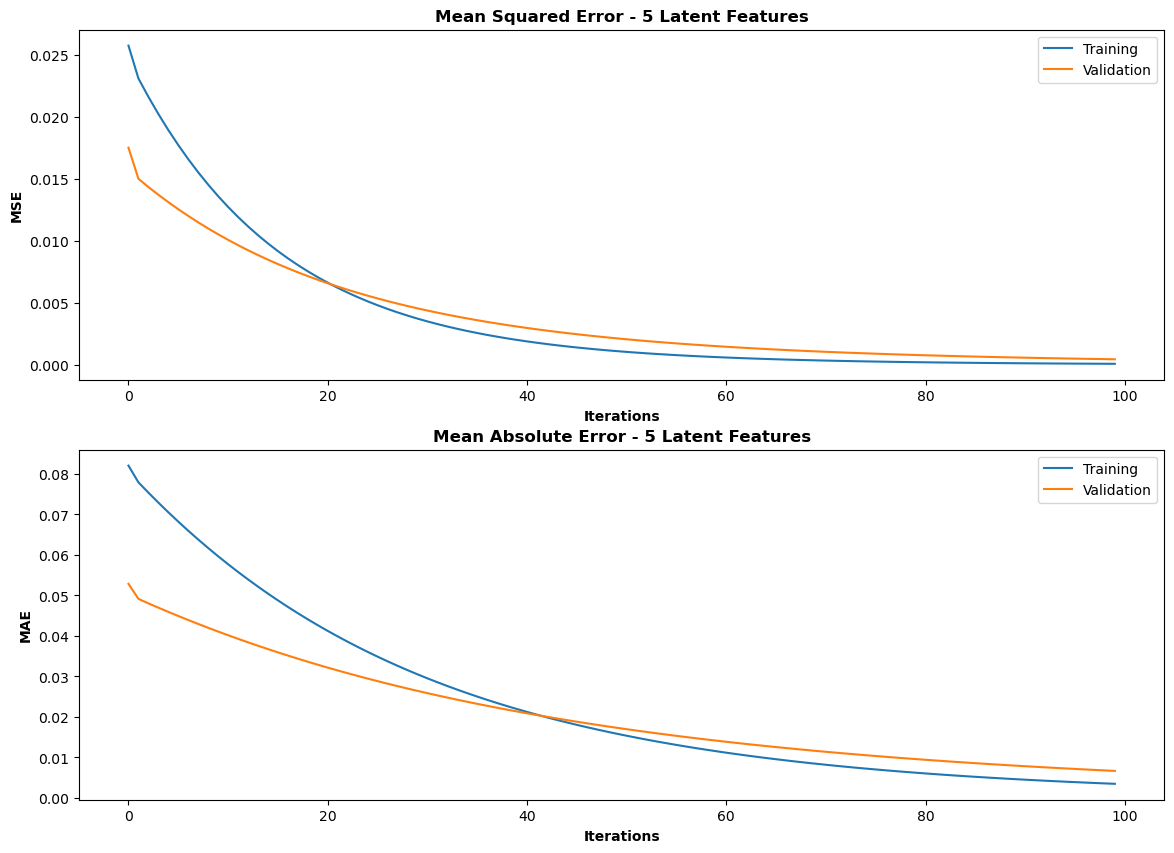

In [75]:
iters = 100
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(range(iters), train_mse5, label = 'Training')
ax1.plot(range(iters), val_mse5, label = 'Validation')
ax1.set_title('Mean Squared Error - 5 Latent Features', fontweight = 'bold')
ax1.set_xlabel('Iterations', fontweight = 'bold')
ax1.set_ylabel('MSE', fontweight = 'bold')
ax1.legend(loc = 'upper right')

ax2.plot(range(iters), train_mae5, label = 'Training')
ax2.plot(range(iters), val_mae5, label = 'Validation')
ax2.set_title('Mean Absolute Error - 5 Latent Features', fontweight = 'bold')
ax2.set_xlabel('Iterations', fontweight = 'bold')
ax2.set_ylabel('MAE', fontweight = 'bold')
ax2.legend(loc = 'upper right');

In [76]:
# fit and validate model using FunkSVD with latent features = 10
train_mse10, train_mae10, val_mse10, val_mae10 = rec.fit(train_df, val_df, latent_features = 10)

Optimization Statistics - 10 Latent Features
Iteration 1
MSE: train = 0.0194, valid. = 0.0128
MAE: train = 0.0658, valid. = 0.0420
----------------------------------------
Iteration 16
MSE: train = 0.0078, valid. = 0.0057
MAE: train = 0.0449, valid. = 0.0301
----------------------------------------
Iteration 31
MSE: train = 0.0047, valid. = 0.0041
MAE: train = 0.0345, valid. = 0.0253
----------------------------------------
Iteration 46
MSE: train = 0.0028, valid. = 0.0029
MAE: train = 0.0265, valid. = 0.0213
----------------------------------------
Iteration 61
MSE: train = 0.0017, valid. = 0.0021
MAE: train = 0.0205, valid. = 0.0180
----------------------------------------
Iteration 76
MSE: train = 0.0011, valid. = 0.0016
MAE: train = 0.0159, valid. = 0.0153
----------------------------------------
Iteration 91
MSE: train = 0.0007, valid. = 0.0012
MAE: train = 0.0123, valid. = 0.0130
----------------------------------------


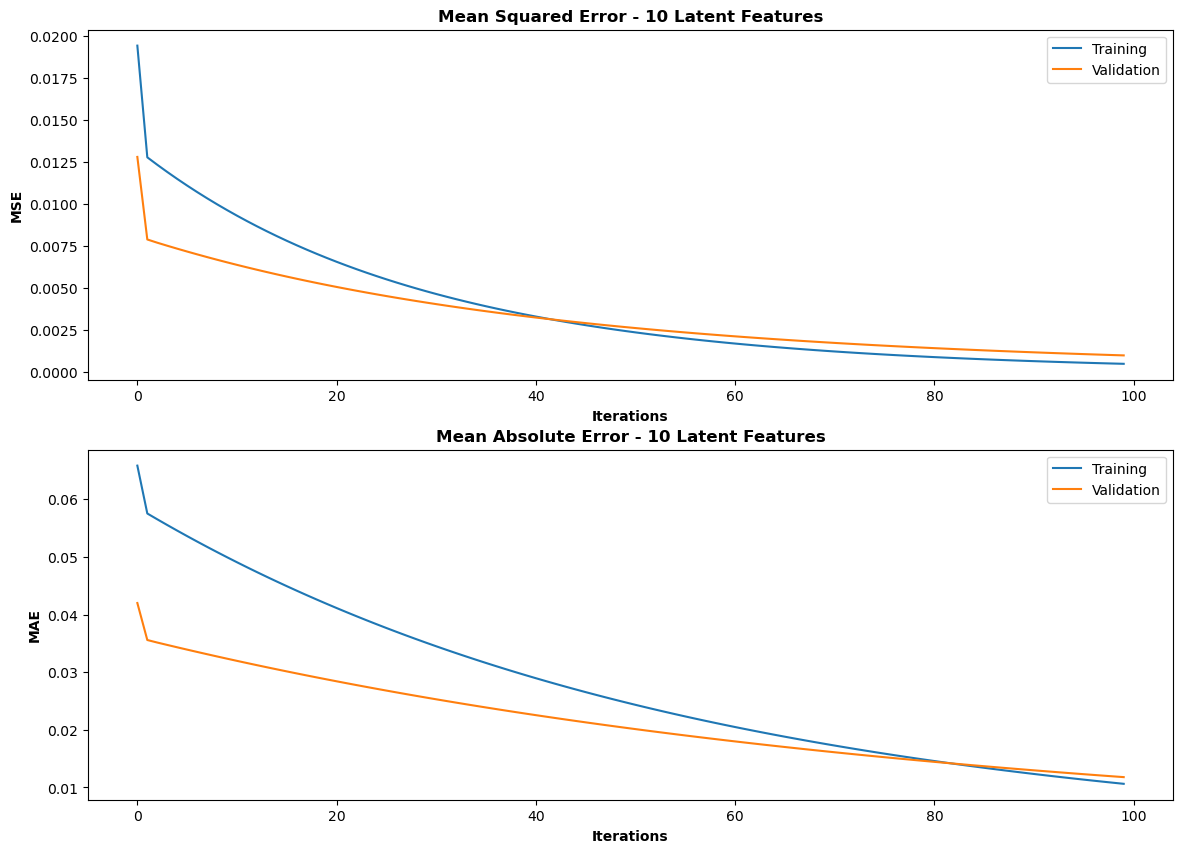

In [77]:
iters = 100
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(range(iters), train_mse10, label = 'Training')
ax1.plot(range(iters), val_mse10, label = 'Validation')
ax1.set_title('Mean Squared Error - 10 Latent Features', fontweight = 'bold')
ax1.set_xlabel('Iterations', fontweight = 'bold')
ax1.set_ylabel('MSE', fontweight = 'bold')
ax1.legend(loc = 'upper right')

ax2.plot(range(iters), train_mae10, label = 'Training')
ax2.plot(range(iters), val_mae10, label = 'Validation')
ax2.set_title('Mean Absolute Error - 10 Latent Features', fontweight = 'bold')
ax2.set_xlabel('Iterations', fontweight = 'bold')
ax2.set_ylabel('MAE', fontweight = 'bold')
ax2.legend(loc = 'upper right');

In [78]:
# fit and validate model using FunkSVD with latent features = 15
train_mse15, train_mae15, val_mse15, val_mae15 = rec.fit(train_df, val_df, latent_features=15)

Optimization Statistics - 15 Latent Features
Iteration 1
MSE: train = 0.0192, valid. = 0.0153
MAE: train = 0.0588, valid. = 0.0395
----------------------------------------
Iteration 16
MSE: train = 0.0063, valid. = 0.0043
MAE: train = 0.0404, valid. = 0.0261
----------------------------------------
Iteration 31
MSE: train = 0.0044, valid. = 0.0034
MAE: train = 0.0337, valid. = 0.0231
----------------------------------------
Iteration 46
MSE: train = 0.0031, valid. = 0.0027
MAE: train = 0.0282, valid. = 0.0206
----------------------------------------
Iteration 61
MSE: train = 0.0022, valid. = 0.0022
MAE: train = 0.0236, valid. = 0.0183
----------------------------------------
Iteration 76
MSE: train = 0.0016, valid. = 0.0017
MAE: train = 0.0198, valid. = 0.0163
----------------------------------------
Iteration 91
MSE: train = 0.0011, valid. = 0.0014
MAE: train = 0.0166, valid. = 0.0146
----------------------------------------


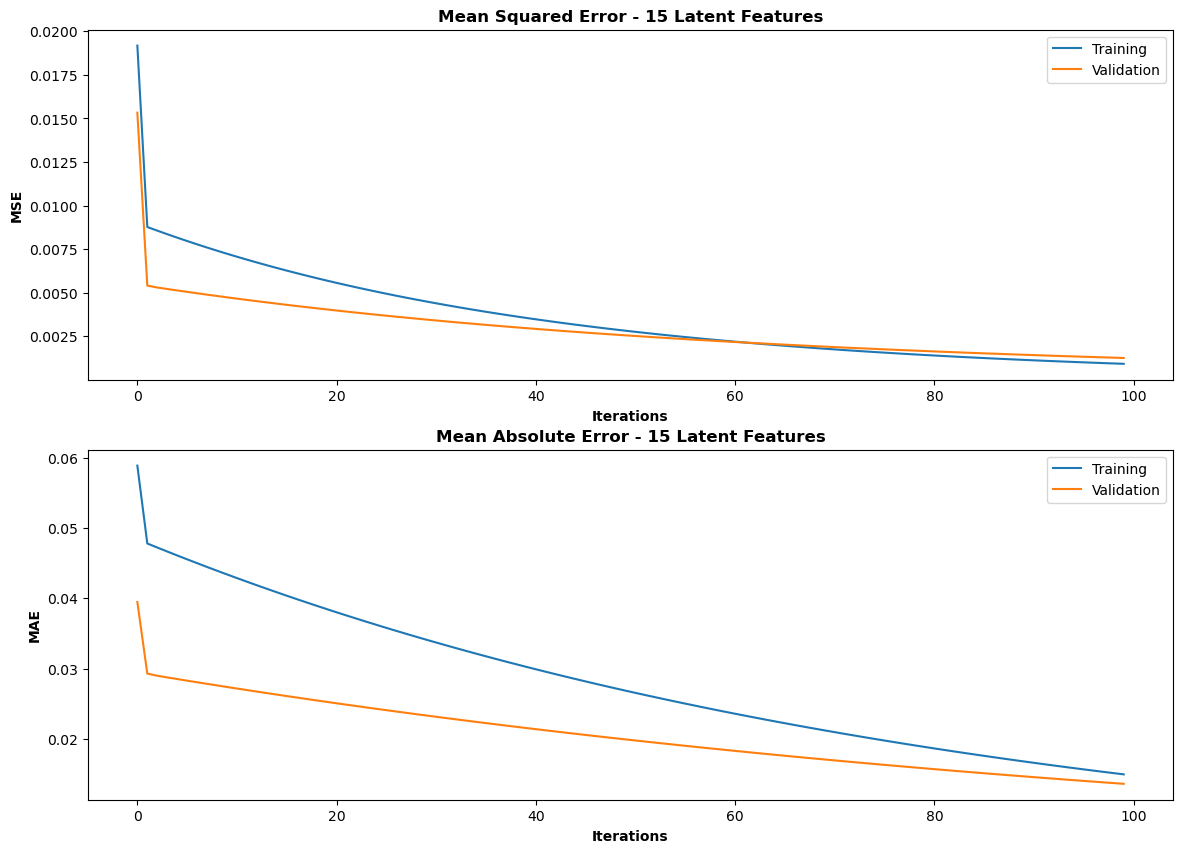

In [79]:
iters = 100
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(range(iters), train_mse15, label = 'Training')
ax1.plot(range(iters), val_mse15, label = 'Validation')
ax1.set_title('Mean Squared Error - 15 Latent Features', fontweight = 'bold')
ax1.set_xlabel('Iterations', fontweight = 'bold')
ax1.set_ylabel('MSE', fontweight = 'bold')
ax1.legend(loc = 'upper right')

ax2.plot(range(iters), train_mae15, label = 'Training')
ax2.plot(range(iters), val_mae15, label = 'Validation')
ax2.set_title('Mean Absolute Error - 15 Latent Features', fontweight = 'bold')
ax2.set_xlabel('Iterations', fontweight = 'bold')
ax2.set_ylabel('MAE', fontweight = 'bold')
ax2.legend(loc = 'upper right');

In [80]:
# fit FunkSVD on training dataframe with latent features = 20
train_mse20, train_mae20, val_mse20, val_mae20 = rec.fit(train_df, val_df, latent_features=20)

Optimization Statistics - 20 Latent Features
Iteration 1
MSE: train = 0.0225, valid. = 0.0175
MAE: train = 0.0558, valid. = 0.0388
----------------------------------------
Iteration 16
MSE: train = 0.0051, valid. = 0.0034
MAE: train = 0.0365, valid. = 0.0234
----------------------------------------
Iteration 31
MSE: train = 0.0039, valid. = 0.0029
MAE: train = 0.0318, valid. = 0.0214
----------------------------------------
Iteration 46
MSE: train = 0.0030, valid. = 0.0024
MAE: train = 0.0277, valid. = 0.0195
----------------------------------------
Iteration 61
MSE: train = 0.0023, valid. = 0.0020
MAE: train = 0.0242, valid. = 0.0179
----------------------------------------
Iteration 76
MSE: train = 0.0018, valid. = 0.0017
MAE: train = 0.0212, valid. = 0.0163
----------------------------------------
Iteration 91
MSE: train = 0.0014, valid. = 0.0015
MAE: train = 0.0185, valid. = 0.0150
----------------------------------------


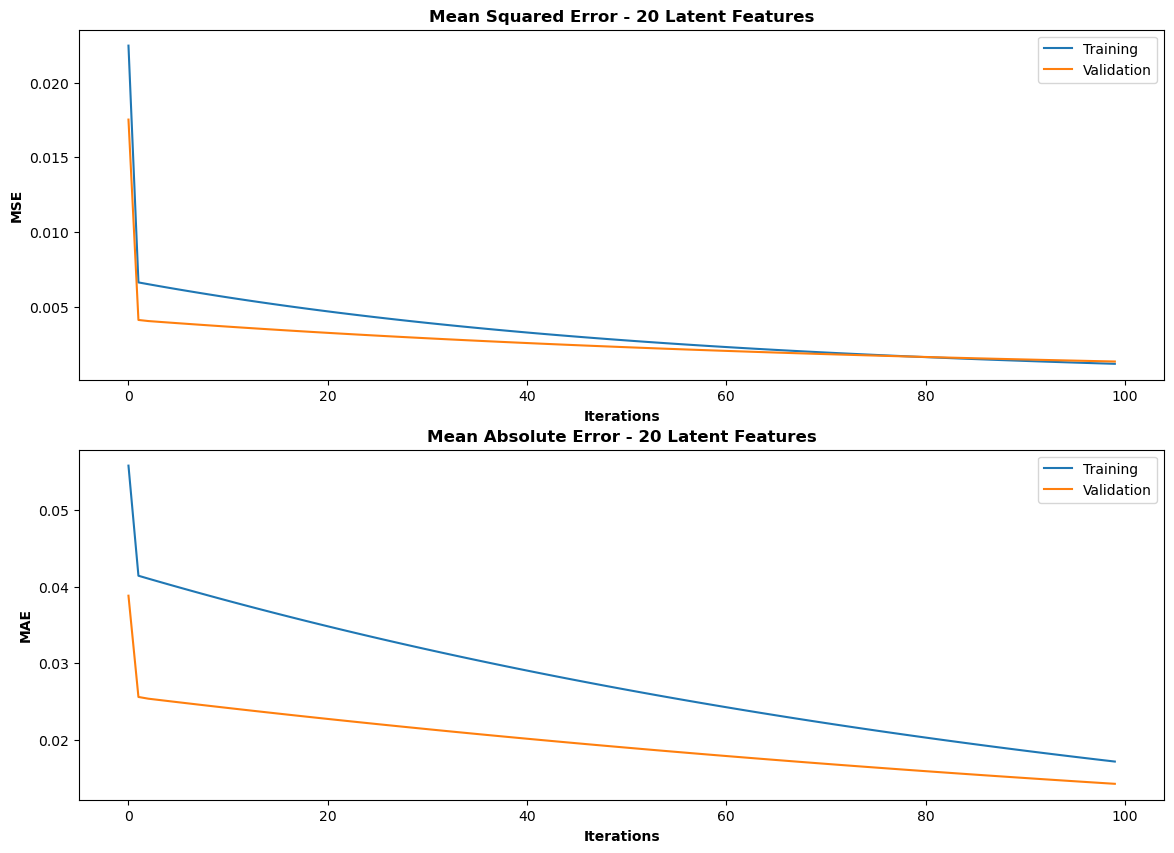

In [81]:
iters = 100
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(range(iters), train_mse20, label = 'Training')
ax1.plot(range(iters), val_mse20, label = 'Validation')
ax1.set_title('Mean Squared Error - 20 Latent Features', fontweight = 'bold')
ax1.set_xlabel('Iterations', fontweight = 'bold')
ax1.set_ylabel('MSE', fontweight = 'bold')
ax1.legend(loc = 'upper right')

ax2.plot(range(iters), train_mae20, label = 'Training')
ax2.plot(range(iters), val_mae20, label = 'Validation')
ax2.set_title('Mean Absolute Error - 20 Latent Features', fontweight = 'bold')
ax2.set_xlabel('Iterations', fontweight = 'bold')
ax2.set_ylabel('MAE', fontweight = 'bold')
ax2.legend(loc = 'upper right');

In [82]:
# predict reaction for customer_id / offer_id according to FunkSVD on training data
customer_id = 13234
offer_id = 8
pred = rec.predict_offer(customer_id, offer_id)

For user 13234, we predict a 1.0431879530521975 rating for offer 8.


In [83]:
# make recommendations according to FunkSVD on training data - valid customer
_id = 1079
rec_type = 'customer'
rec_num = 5
rec_ids, rec_offers = rec.make_recs(_id, rec_type)

Top offers for customer 1079 according to prediction: [10  3  0  7  6]


In [84]:
# make recommendations according to FunkSVD on training data - invalid customer
_id = 99999
rec_type = 'customer'
rec_num = 5
rec_ids, rec_offers = rec.make_recs(_id, rec_type)

The top 5 offer recommendations for customer 99999:
Because this user wasn't in our database, we are giving back the top offer recommendations for all users.
Top offer recommendations: [4, 9, 1, 8, 7]


#### Plot the MSEs from the four FunkSVD fits against the training data.

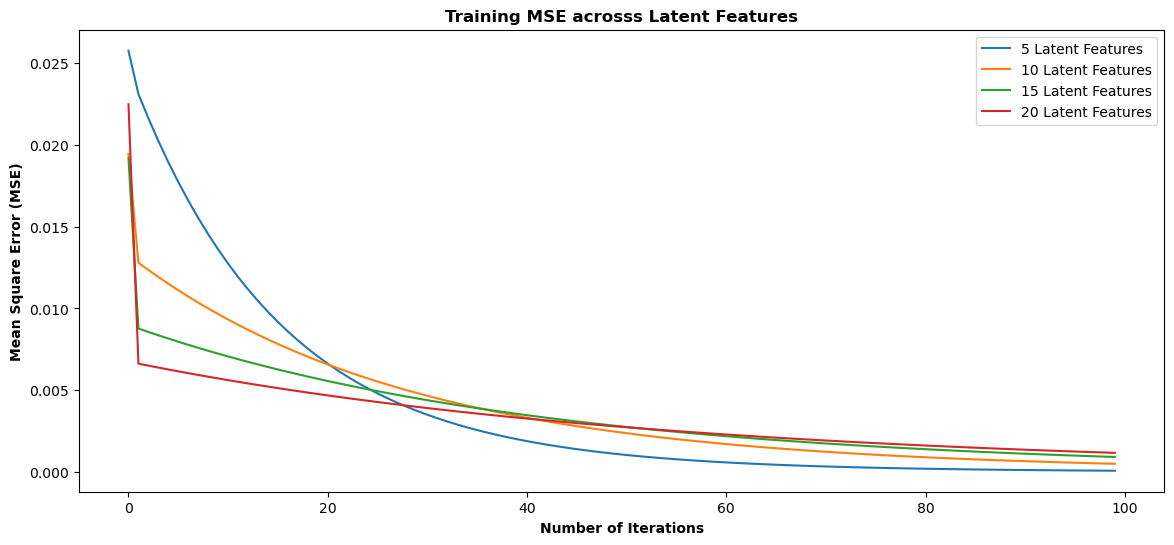

In [85]:
# set up plots
iters = 100
plt.figure(figsize = (14, 6))
plt.plot(range(iters), train_mse5, label = '5 Latent Features')
plt.plot(range(iters), train_mse10, label = '10 Latent Features')
plt.plot(range(iters), train_mse15, label = '15 Latent Features')
plt.plot(range(iters), train_mse20, label = '20 Latent Features')

plt.xlabel('Number of Iterations', weight = 'bold')
plt.ylabel('Mean Square Error (MSE)', weight = 'bold')
plt.title('Training MSE acrosss Latent Features', weight = 'bold')

plt.legend();

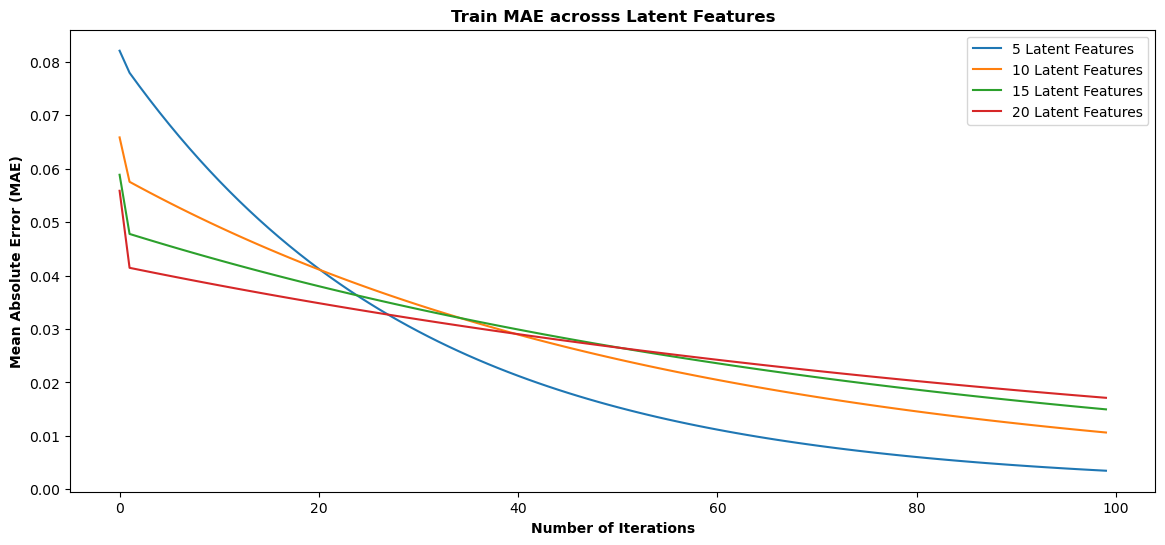

In [86]:
# set up plots
iters = 100
plt.figure(figsize = (14, 6))
plt.plot(range(iters), train_mae5, label = '5 Latent Features')
plt.plot(range(iters), train_mae10, label = '10 Latent Features')
plt.plot(range(iters), train_mae15, label = '15 Latent Features')
plt.plot(range(iters), train_mae20, label = '20 Latent Features')

plt.xlabel('Number of Iterations', weight = 'bold')
plt.ylabel('Mean Absolute Error (MAE)', weight = 'bold')
plt.title('Train MAE acrosss Latent Features', weight = 'bold')

plt.legend();

#### Plot the MSEs from the four FunkSVD fits against the validation data.

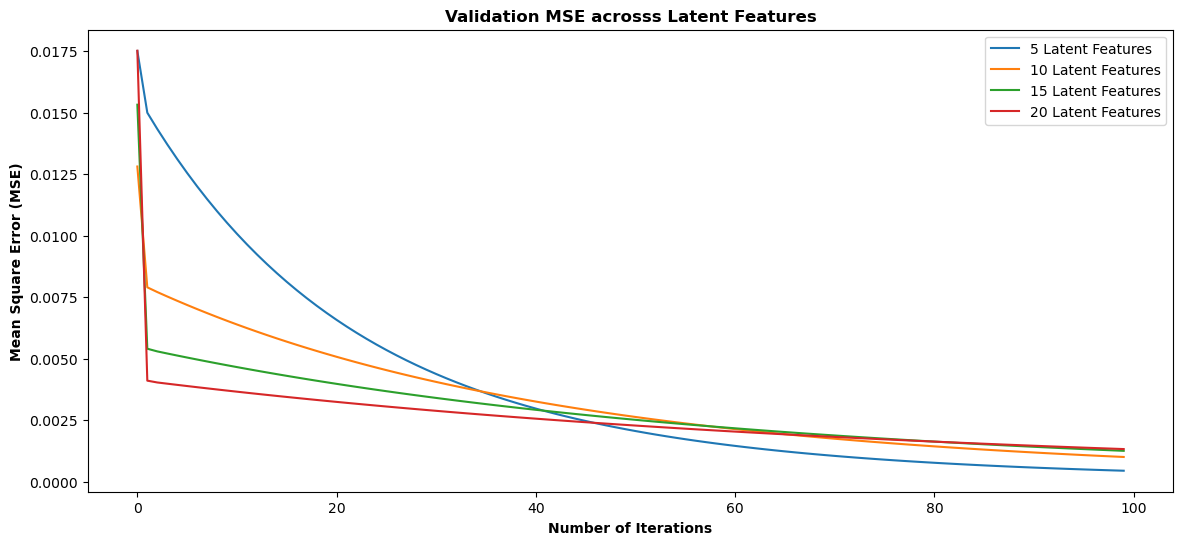

In [87]:
# set up plots
iters = 100
plt.figure(figsize = (14, 6))
plt.plot(range(iters), val_mse5, label = '5 Latent Features')
plt.plot(range(iters), val_mse10, label = '10 Latent Features')
plt.plot(range(iters), val_mse15, label = '15 Latent Features')
plt.plot(range(iters), val_mse20, label = '20 Latent Features')

plt.xlabel('Number of Iterations', weight = 'bold')
plt.ylabel('Mean Square Error (MSE)', weight = 'bold')
plt.title('Validation MSE acrosss Latent Features', weight = 'bold')

plt.legend();

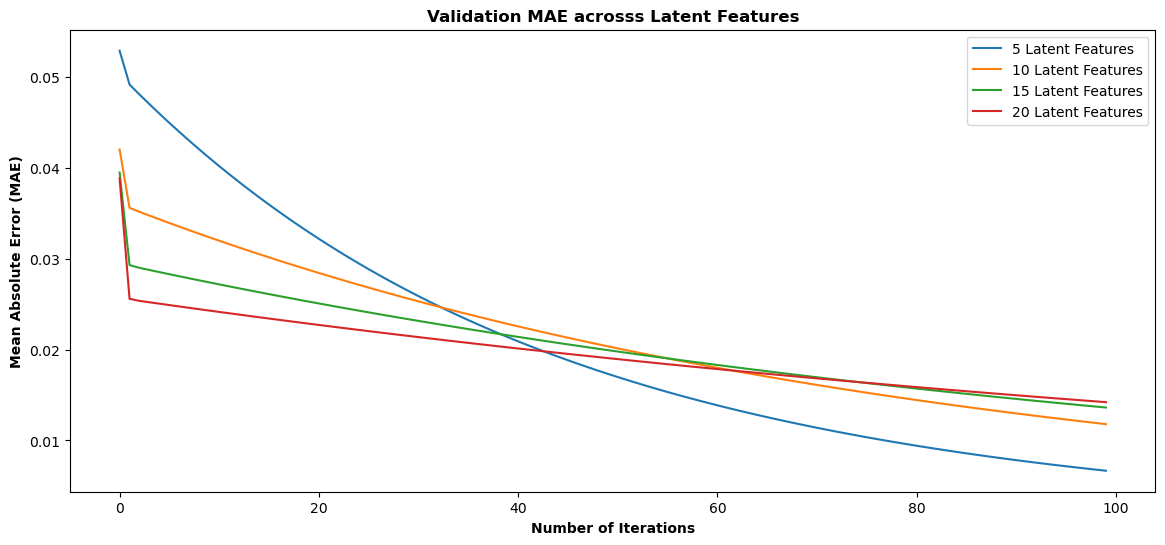

In [88]:
# set up plots
iters = 100
plt.figure(figsize = (14, 6))
plt.plot(range(iters), val_mae5, label = '5 Latent Features')
plt.plot(range(iters), val_mae10, label = '10 Latent Features')
plt.plot(range(iters), val_mae15, label = '15 Latent Features')
plt.plot(range(iters), val_mae20, label = '20 Latent Features')

plt.xlabel('Number of Iterations', weight = 'bold')
plt.ylabel('Mean Absolute Error (MAE)', weight = 'bold')
plt.title('Validation MAE acrosss Latent Features', weight = 'bold')

plt.legend();

In [89]:
# create dataframe from mean square errors of FunkSVD runs
cols = ['train_mse5', 'val_mse5', 'train_mse10', 'val_mse10', 'train_mse15', 'val_mse15', 
        'train_mse20', 'test_mse20']
train_val_mse = pd.DataFrame(data = [train_mse5, val_mse5, train_mse10, val_mse10, train_mse15, val_mse15,
                                      train_mse20, val_mse20]).T
train_val_mse.set_axis(cols, axis=1,inplace=True)
train_val_mse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_mse5   100 non-null    float64
 1   val_mse5     100 non-null    float64
 2   train_mse10  100 non-null    float64
 3   val_mse10    100 non-null    float64
 4   train_mse15  100 non-null    float64
 5   val_mse15    100 non-null    float64
 6   train_mse20  100 non-null    float64
 7   test_mse20   100 non-null    float64
dtypes: float64(8)
memory usage: 6.4 KB


In [90]:
train_val_mse.describe()

,train_mse5,val_mse5,train_mse10,val_mse10,train_mse15,val_mse15,train_mse20,test_mse20
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.003942,0.003834,0.003850,0.003314,0.003589,0.002907,0.003313,0.002575
std,0.005893,0.003991,0.003660,0.002147,0.002701,0.001720,0.002479,0.001706
min,0.000080,0.000446,0.000504,0.001004,0.000919,0.001254,0.001171,0.001326
25%,0.000271,0.000916,0.001081,0.001606,0.001587,0.001768,0.001789,0.001736
50%,0.001072,0.002096,0.002413,0.002659,0.002786,0.002534,0.002760,0.002295
75%,0.004883,0.005409,0.005579,0.004561,0.004970,0.003693,0.004297,0.003066
max,0.025746,0.017515,0.019438,0.012815,0.019175,0.015329,0.022475,0.017523


In [91]:
train_val_mse_df = pd.DataFrame(train_val_mse.describe().T)

In [92]:
train_val_mse_df

,count,mean,std,min,25%,50%,75%,max
train_mse5,100.0,0.003942,0.005893,0.000080,0.000271,0.001072,0.004883,0.025746
val_mse5,100.0,0.003834,0.003991,0.000446,0.000916,0.002096,0.005409,0.017515
train_mse10,100.0,0.003850,0.003660,0.000504,0.001081,0.002413,0.005579,0.019438
val_mse10,100.0,0.003314,0.002147,0.001004,0.001606,0.002659,0.004561,0.012815
train_mse15,100.0,0.003589,0.002701,0.000919,0.001587,0.002786,0.004970,0.019175
val_mse15,100.0,0.002907,0.001720,0.001254,0.001768,0.002534,0.003693,0.015329
train_mse20,100.0,0.003313,0.002479,0.001171,0.001789,0.002760,0.004297,0.022475
test_mse20,100.0,0.002575,0.001706,0.001326,0.001736,0.002295,0.003066,0.017523


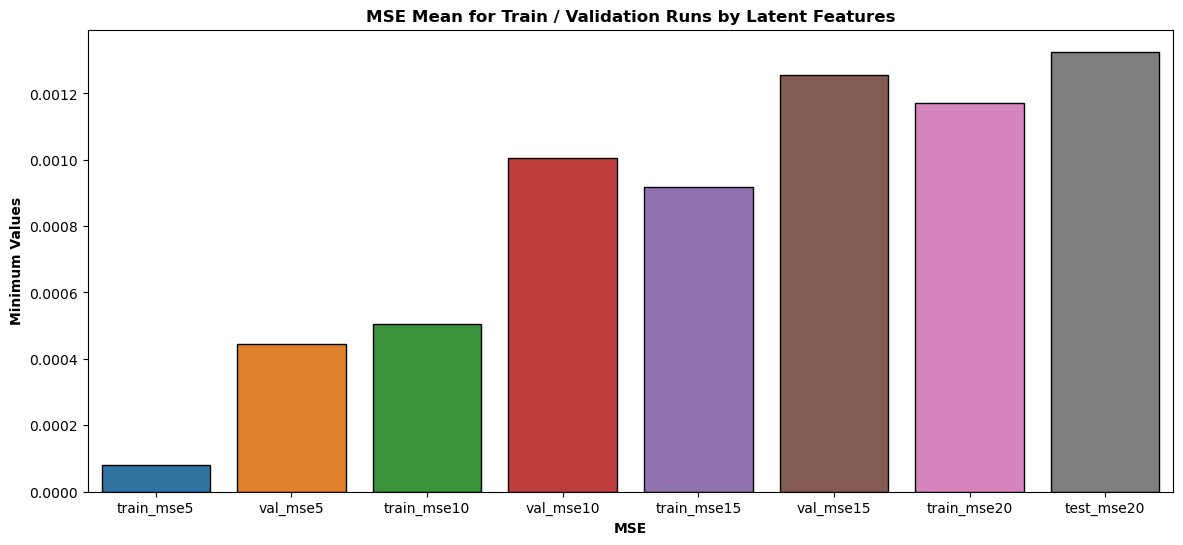

In [100]:
plt.figure(figsize = (14, 6))
sns.barplot(data = train_val_mse_df, x = train_val_mse_df.index, y = 'min',
           edgecolor = 'black')
plt.xlabel('MSE', weight = 'bold')
plt.ylabel('Minimum Values', weight = 'bold')
plt.title('MSE Mean for Train / Validation Runs by Latent Features', weight = 'bold');

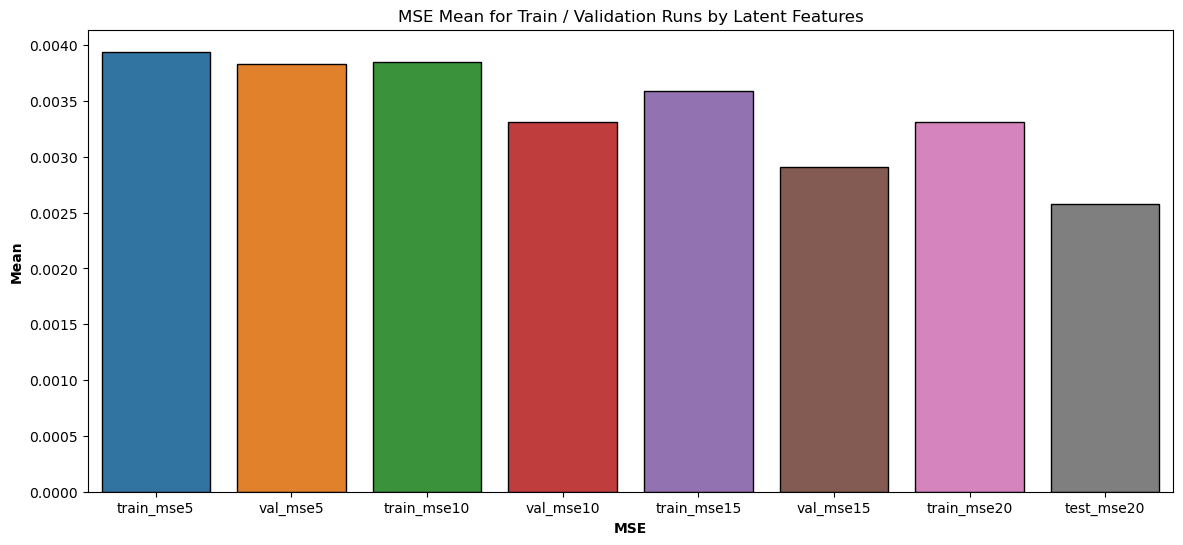

In [96]:
plt.figure(figsize = (14, 6))
sns.barplot(data = train_val_mse_df, x = train_val_mse_df.index, y = 'mean',
           edgecolor = 'black')
plt.xlabel('MSE', weight = 'bold')
plt.ylabel('Mean', weight = 'bold')
plt.title('MSE Mean for Train / Validation Runs by Latent Features', weight = 'bold');

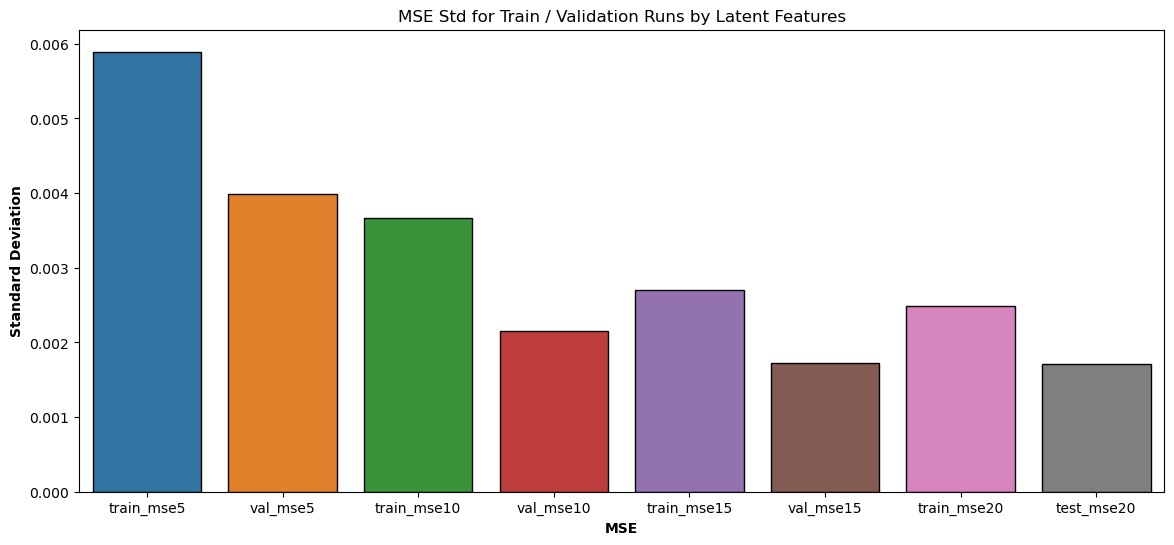

In [99]:
plt.figure(figsize = (14, 6))
sns.barplot(data = train_val_mse_df, x = train_val_mse_df.index, y = 'std',
           edgecolor = 'black')
plt.xlabel('MSE', weight = 'bold')
plt.ylabel('Standard Deviation', weight = 'bold')
plt.title('MSE Std for Train / Validation Runs by Latent Features', weight = 'bold');

In [101]:
# create dataframe from mean square errors of FunkSVD runs
cols = ['train_mae5', 'val_mae5', 'train_mae10', 'val_mae10', 'train_mae15', 'val_mae15', 
        'train_mae20', 'test_mae20']
train_val_mae = pd.DataFrame(data = [train_mae5, val_mae5, train_mae10, val_mae10, train_mae15, val_mae15,
                                      train_mae20, val_mae20]).T
train_val_mae.set_axis(cols, axis=1,inplace=True)
train_val_mae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_mae5   100 non-null    float64
 1   val_mae5     100 non-null    float64
 2   train_mae10  100 non-null    float64
 3   val_mae10    100 non-null    float64
 4   train_mae15  100 non-null    float64
 5   val_mae15    100 non-null    float64
 6   train_mae20  100 non-null    float64
 7   test_mae20   100 non-null    float64
dtypes: float64(8)
memory usage: 6.4 KB


In [102]:
train_val_mae_df = pd.DataFrame(train_val_mae.describe().T)

In [103]:
train_val_mae_df

,count,mean,std,min,25%,50%,75%,max
train_mae5,100.0,0.023886,0.021032,0.003490,0.007195,0.015610,0.035181,0.082044
val_mae5,100.0,0.020863,0.012335,0.006674,0.010503,0.017152,0.028996,0.052862
train_mae10,100.0,0.027960,0.013904,0.010638,0.016072,0.024550,0.037829,0.065831
val_mae10,100.0,0.021528,0.007152,0.011798,0.015377,0.020241,0.026888,0.042001
train_mae15,100.0,0.028478,0.009949,0.014968,0.019947,0.026706,0.035892,0.058845
val_mae15,100.0,0.020527,0.004909,0.013625,0.016410,0.019858,0.024137,0.039466
train_mae20,100.0,0.027740,0.007595,0.017128,0.021333,0.026643,0.033351,0.055849
test_mae20,100.0,0.019454,0.003822,0.014216,0.016414,0.019003,0.022059,0.038830
